#Load and Check for Data Quality Issues

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel("Online_Retail.xlsx")

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [3]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 5268


Drawing a heatmap to know the relationship between the variables

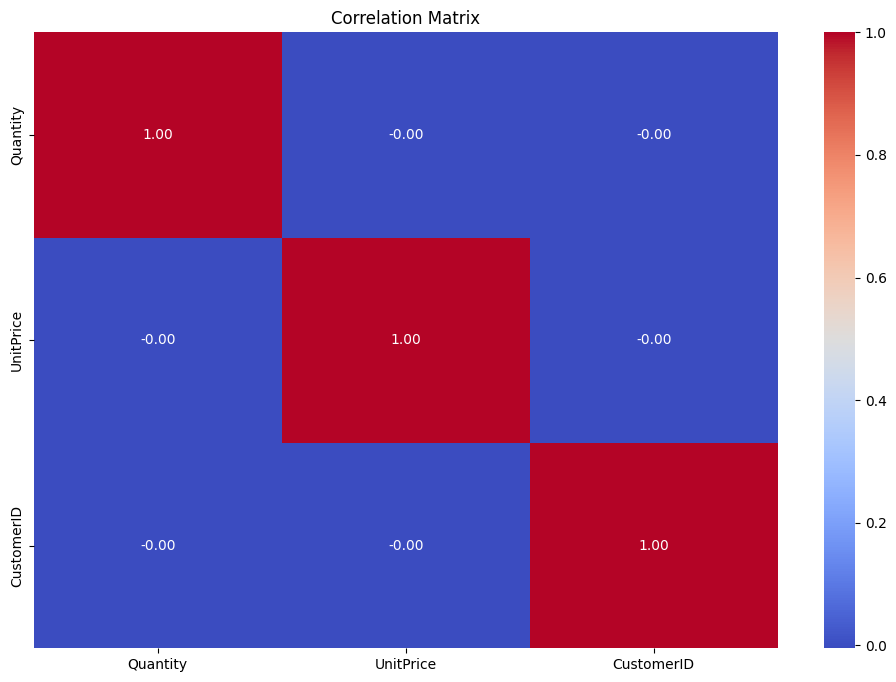

In [5]:
numeric_df = df.select_dtypes(include=[np.number])

corr = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Create Meaningful Features

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
recent_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (recent_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df = df.merge(rfm, on='CustomerID', how='left')
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


---
Segmenting the customers based upon there purchasing pattern

K-means and Hierarchical Clustering

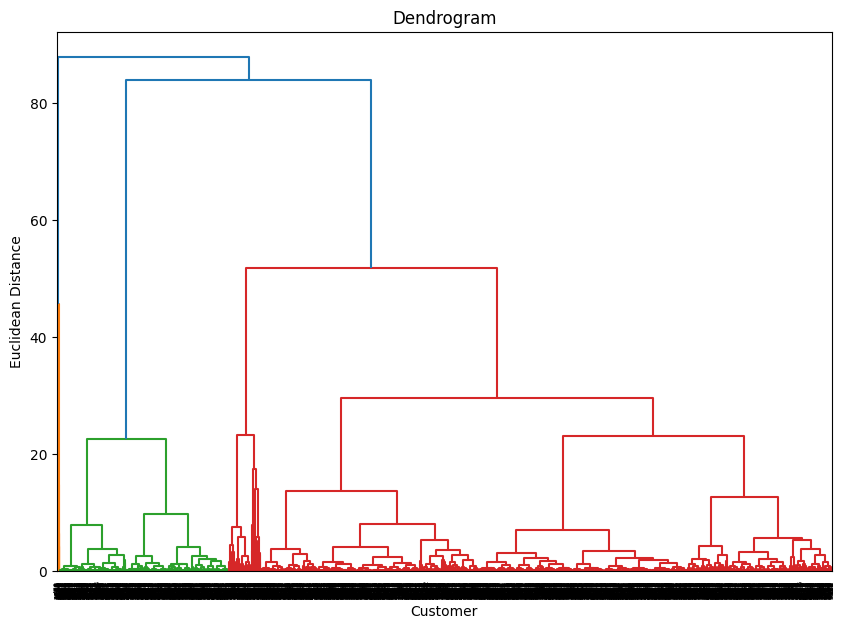

In [7]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
Z = linkage(X_scaled, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Customer")
plt.ylabel("Euclidean Distance")
plt.show()


---
 Comparing the Distance Measures (Euclidean vs Manhattan)

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import manhattan_distances

kmeans_euclidean = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Euclidean'] = kmeans_euclidean.fit_predict(X_scaled)

silhouette_euclidean = silhouette_score(X_scaled, rfm['KMeans_Euclidean'])
print(f"Silhouette Score (Euclidean): {silhouette_euclidean}")

X_manhattan = manhattan_distances(X_scaled)
kmeans_manhattan = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Manhattan'] = kmeans_manhattan.fit_predict(X_manhattan)

silhouette_manhattan = silhouette_score(X_manhattan, rfm['KMeans_Manhattan'])
print(f"Silhouette Score (Manhattan): {silhouette_manhattan}")


Silhouette Score (Euclidean): 0.6161144819517276
Silhouette Score (Manhattan): 0.5708329085832652


---
Applying the supervised the learning models

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(random_state=42)
dt_mae, dt_rmse, dt_r2 = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

rf_model = RandomForestRegressor(random_state=42)
rf_mae, rf_rmse, rf_r2 = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_mae, gb_rmse, gb_r2 = evaluate_model(gb_model, X_train, y_train, X_test, y_test)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_mae, xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

print(f"Decision Tree - MAE: {dt_mae}, RMSE: {dt_rmse}, R²: {dt_r2}")
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}, R²: {rf_r2}")
print(f"Gradient Boosting - MAE: {gb_mae}, RMSE: {gb_rmse}, R²: {gb_r2}")
print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}, R²: {xgb_r2}")


Decision Tree - MAE: 1920.0445289192694, RMSE: 10694.671528785824, R²: -0.32149631233986486
Random Forest - MAE: 1829.7154041149745, RMSE: 10145.077889157961, R²: -0.18916419985153676
Gradient Boosting - MAE: 1554.135197544053, RMSE: 9408.616769667791, R²: -0.022780909815352857
XGBoost - MAE: 1690.99910220801, RMSE: 9508.777528368497, R²: -0.044673138513311006


# 4. Apply PCA for reducing the features and fast processing of the data

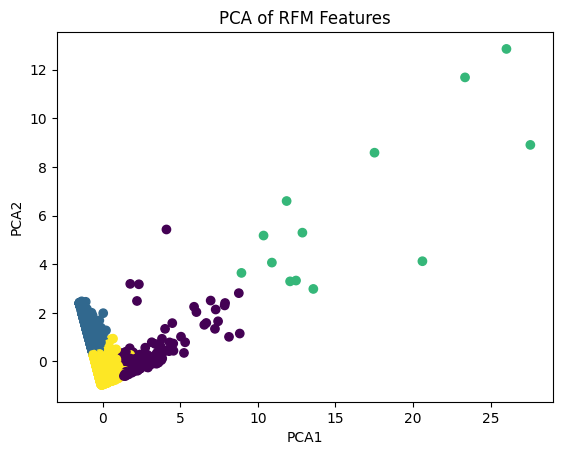

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

rfm['PCA1'], rfm['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['KMeans_Cluster'], cmap='viridis')
plt.title('PCA of RFM Features')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


# 5. Regularization to Prevent Overfitting

In [11]:
from sklearn.linear_model import Ridge, Lasso

ridge_model = Ridge(alpha=0.1)
ridge_mae, ridge_rmse, ridge_r2 = evaluate_model(ridge_model, X_train, y_train, X_test, y_test)

lasso_model = Lasso(alpha=0.1)
lasso_mae, lasso_rmse, lasso_r2 = evaluate_model(lasso_model, X_train, y_train, X_test, y_test)

print(f"Ridge - MAE: {ridge_mae}, RMSE: {ridge_rmse}, R²: {ridge_r2}")
print(f"Lasso - MAE: {lasso_mae}, RMSE: {lasso_rmse}, R²: {lasso_r2}")


Ridge - MAE: 1449.9760003579413, RMSE: 8079.519440950411, R²: 0.24577293049138904
Lasso - MAE: 1449.9732219419373, RMSE: 8079.519086514816, R²: 0.24577299666485797
